# Web Voyager

THis is a vision-enabled web-browsing agent capable of controlling the mouse and keyboard

source code: https://langchain-ai.github.io/langgraph/tutorials/web-navigation/web_voyager/

# Setup Environment
Set up the environment by importing necessary libraries and setting up API keys.

In [14]:
# # Install required packages
# !pip install --quiet langgraph langsmith langchain_openai playwright nest_asyncio
# # Install Playwright browser
# !playwright install

# Import necessary libraries
import os
import nest_asyncio

from dotenv import load_dotenv

# Load environment variables
load_dotenv()

# Set OpenAI API key
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")

# Apply nest_asyncio for running async code in Jupyter
nest_asyncio.apply()

# Define A Helper File

Make sure to create a JS code file called mark_page.js in the same folder as the notebook

# Define Agent State
Define the `AgentState` class to represent the state of the agent, including the webpage, bounding boxes, and predictions.

In [15]:
from typing import List, Optional, Any, Dict, Literal
from pydantic import BaseModel, Field, ConfigDict
from langchain_core.messages import BaseMessage
from playwright.async_api import Page
import base64
import asyncio

# Define the BBox model
class BBox(BaseModel):
    """
    Represents a bounding box on the webpage with its coordinates and metadata.
    """
    x: float
    y: float
    text: str
    type: str
    ariaLabel: Optional[str] = None
    id: Optional[str] = None

    @property
    def description(self) -> str:
        """Generate a description for the bounding box."""
        label = self.ariaLabel or self.text or "No label"
        return f'{self.id} (<{self.type}/>): "{label}"'
    

# Define the Prediction model
class Prediction(BaseModel):
    """
    Represents the agent's predicted action and its arguments.
    """
    action: str = Field(description="The action to be performed by the agent")
    args: List[str] = Field(default_factory=list, description="Arguments for the action")

from typing import List, Literal, Optional, Any, Dict
from langchain_core.messages import BaseMessage
from pydantic import BaseModel, Field

class Observation(BaseModel):
    """A single entry in the scratchpad"""
    step: int = 0
    action: str
    status: Literal["success", "warning", "error"]
    details: str
    
    def format(self) -> str:
        """Format the entry for display"""
        indicator = "✓" if self.status == "success" else "⚠️" if self.status == "warning" else "✗"
        return f"{self.step}. {indicator} {self.action.upper()}: {self.details}"


# Define the AgentState model
class AgentState(BaseModel):
    """
    Represents the state of the agent during execution.
    """
    page: Page = Field(default=None, exclude=True)  # Non-serializable Playwright page object
    input: str = ""
    img: Optional[str] = ""
    bboxes: Optional[List[BBox]] = Field(default_factory=list, description="List of bounding boxes annotated on the webpage")
    prediction: Optional[Prediction] = Field(description="The agent's predicted action and arguments")
    scratchpad: Optional[List[BaseMessage]] = Field(default_factory=list, description="Intermediate steps or system messages")
    observation: Optional[str] = ""
    ids: Optional[List[int]] = Field(default_factory=list)
    observations: Optional[List[Observation]] = Field(default_factory=list, description="List of observations made by the agent")

    def add_observation(self, action: str, status: str, details: str) -> None:
        """Add a new observation to the history"""
        step = len(self.observations) + 1
        new_observation = Observation(step=step, action=action, status=status, details=details)
        self.observations.append(new_observation)
        self.observation = new_observation.format()  # Update the current observation string
        
    def check_repeated_failure(self, action: str, args: List[str]) -> Optional[List[Observation]]:
        """Check if this action+args combination has failed before"""
        if not self.observations:
            return None
            
        action_key = f"{action}:{','.join(args)}"
        failures = [
            obs for obs in self.observations 
            if obs.status == "error" and 
            f"{obs.action}:{','.join(args) if 'args' in obs.details else ''}" == action_key
        ]
        
        return failures if failures else None
    
    class Config:
        # Exclude the `page` attribute during serialization
        arbitrary_types_allowed = True
        json_encoders = {
            Page: lambda v: None,  # Prevent serialization of arbitrary objects
        }

# Define Tools
Implement the tools for the agent, such as 

1. `click`, 

2. `type_text`, 

3. `scroll`, 

4. `wait`,

5. `go_back`, 

5. `to_google`.

In [16]:
# Helper function to create structured observations from tool execution
def create_observation(action: str, status: str, details: str) -> Observation:
    """
    Creates a structured observation object.
    
    Args:
        action: The action performed (e.g., "click", "type")
        status: Status indicator ("success", "warning", "error")
        details: Detailed information about the action
    
    Returns:
        Observation object
    """
    return Observation(step=0, action=action, status=status, details=details).format()

In [17]:
import asyncio
import platform

#Tools
# Change these constants to all uppercase
CLICK = "CLICK"
TYPE = "TYPE"
SCROLL = "SCROLL"
WAIT = "WAIT"
GOBACK = "GOBACK"
GOOGLE = "GOOGLE"
APPROVE = "APPROVE"
ANSWER = "ANSWER"
RETRY = "RETRY"


async def click(state: AgentState, name: str = CLICK):
    """
    Simulates a mouse click on a bounding box identified by its label.
    """
    try:
        page = state.page
        click_args = state.prediction.args
        print("Click args: ", click_args)
        
        # Validate arguments
        if click_args is None or len(click_args) != 1:
            # Create a structured observation
            obs = create_observation(
                name, 
                "error",
                f"Invalid arguments: expected 1 argument (box ID), got {click_args}"
            )
            state.observation = obs
            return state
            
        bbox_id = int(click_args[0])
        print("Bbox ID clicked: ", bbox_id)
        
        # Find target element
        try:
            bbox = state.bboxes[bbox_id]
            print("Bbox: ", bbox)
            state.ids.append(bbox_id)
        except IndexError:
            obs = create_observation(
                name,
                "error",
                f"No bounding box found with ID {bbox_id}"
            )
            state.observation = obs
            return state
            
        # Perform action
        x, y = bbox.x, bbox.y
        await page.mouse.click(x, y)
        
        # Create success observation with element details
        element_type = bbox.type
        element_text = bbox.text[:30] + "..." if len(bbox.text) > 30 else bbox.text
        obs = create_observation(
            name,
            "success",
            f"Element {bbox_id} ({element_type}: '{element_text}')"
        )
        state.observation = obs
        
    except Exception as e:
        obs = create_observation(
            name,
            "error",
            f"Exception: {str(e)}"
        )
        state.observation = obs
        print(f"Error in click: {e}")
        
    return state


async def scroll(state: AgentState, name: str = SCROLL):
    """
    Simulates scrolling within the webpage or a specific element.
    """
    try:
        page = state.page
        scroll_args = state.prediction.args
        
        # Validate arguments
        if scroll_args is None or len(scroll_args) != 2:
            obs = create_observation(
                name, 
                "error",
                f"Invalid arguments: expected 2 arguments (target, direction), got {scroll_args}"
            )
            state.observation = obs
            return state
            
        target, direction = scroll_args

        # Handle window scrolling
        if target.upper() == "WINDOW":
            scroll_amount = 500
            scroll_direction = -scroll_amount if direction.lower() == "up" else scroll_amount
            await page.evaluate(f"window.scrollBy(0, {scroll_direction})")
            
            obs = create_observation(
                name,
                "success",
                f"Window scrolled {direction.lower()}"
            )
        else:
            # Handle element scrolling
            scroll_amount = 200
            try:
                target_id = int(target)
                bbox = state.bboxes[target_id]
                x, y = bbox.x, bbox.y
                await page.mouse.move(x, y)
                scroll_direction = -scroll_amount if direction.lower() == "up" else scroll_amount
                await page.mouse.wheel(0, scroll_direction)
                
                obs = create_observation(
                    name,
                    "success",
                    f"Element {target_id} ({bbox.type}) scrolled {direction.lower()}"
                )
            except (ValueError, IndexError):
                obs = create_observation(
                    name,
                    "error",
                    f"Invalid target: {target} is not 'WINDOW' or a valid box ID"
                )
                state.observation = obs
                return state
        
        state.observation = obs.format()
        
    except Exception as e:
        obs = create_observation(
            name,
            "error",
            f"Exception: {str(e)}"
        )
        state.observation = obs
        print(f"Error in scroll: {e}")
        
    return state



async def type_text(state: AgentState, name: str = TYPE):
    """
    Simulates typing text into an input field identified by a bounding box label.
    """
    try:
        page = state.page
        type_args = state.prediction.args
        
        # Validate arguments
        if type_args is None or len(type_args) != 2:
            obs = create_observation(
                name, 
                "error",
                f"Invalid arguments: expected 2 arguments (box ID, text), got {type_args}"
            )
            state.observation = obs
            return state
            
        bbox_id = int(type_args[0])
        text_content = type_args[1]
        
        # Find target element
        try:
            bbox = state.bboxes[bbox_id]
        except IndexError:
            obs = create_observation(
                name,
                "error",
                f"No bounding box found with ID {bbox_id}"
            )
            state.observation = obs.format()
            return state
            
        # Perform action
        x, y = bbox.x, bbox.y
        await page.mouse.click(x, y)
        select_all = "Meta+A" if platform.system() == "Darwin" else "Control+A"
        await page.keyboard.press(select_all)
        await page.keyboard.press("Backspace")
        await page.keyboard.type(text_content)
        await page.keyboard.press("Enter")
        
        # Create success observation
        safe_text = text_content[:15] + "..." if len(text_content) > 15 else text_content
        obs = create_observation(
            name,
            "success",
            f"Text '{safe_text}' in element {bbox_id} ({bbox.type})"
        )
        state.observation = obs
        
    except Exception as e:
        obs = create_observation(
            name,
            "error",
            f"Exception: {str(e)}"
        )
        state.observation = obs
        print(f"Error in type_text: {e}")
        
    return state


async def wait(state: AgentState, name: str = WAIT):
    """
    Simulates a wait action for a fixed duration.
    """
    try:
        sleep_time = 5
        await asyncio.sleep(sleep_time)
        
        # Create structured observation
        obs = create_observation(
            name,
            "success",
            f"Waited for {sleep_time} seconds"
        )
        state.observation = obs
        
    except Exception as e:
        obs = create_observation(
            name,
            "error",
            f"Exception: {str(e)}"
        )
        state.observation = obs
        print(f"Error in wait: {e}")
        
    return state


async def go_back(state: AgentState, name: str = GOBACK):
    """
    Simulates navigating back to the previous page in the browser.
    """
    try:
        page = state.page
        await page.go_back()
        current_url = page.url
        
        obs = create_observation(
            GOBACK,
            "success",
            f"Navigated back to {current_url}"
        )
        state.observation = obs
        
    except Exception as e:
        obs = create_observation(
            GOBACK,
            "error",
            f"Exception: {str(e)}"
        )
        state.observation = obs
        print(f"Error in go_back: {e}")
        
    return state


async def to_google(state: AgentState, name: str = GOOGLE):
    """
    Simulates navigating to the Google homepage.
    """
    try:
        page = state.page
        await page.goto("https://www.google.com/")
        
        obs = create_observation(
            GOOGLE,
            "success",
            "Navigated to Google homepage"
        )
        state.observation = obs
        
    except Exception as e:
        obs = create_observation(
            GOOGLE,
            "error",
            f"Exception: {str(e)}"
        )
        state.observation = obs
        print(f"Error in to_google: {e}")
        
    return state


async def approve_info_box(state: AgentState, name: str = APPROVE):
    """
    Simulates clicking the 'Approve' button in a Google information box.
    """
    try:
        page = state.page
        approve_args = state.prediction.args
        
        # Validate arguments
        if approve_args is None or len(approve_args) != 1:
            obs = create_observation(
                APPROVE, 
                "error",
                f"Invalid arguments: expected 1 argument (box ID), got {approve_args}"
            )
            state.observation = obs
            return state
            
        bbox_id = int(approve_args[0])
        
        # Find target element
        try:
            bbox = state.bboxes[bbox_id]
            print("Bbox: ", bbox)
        except IndexError:
            obs = create_observation(
                APPROVE,
                "error",
                f"No bounding box found with ID {bbox_id}"
            )
            state.observation = obs
            return state
            
        # Perform action
        x, y = bbox.x, bbox.y
        await page.mouse.click(x, y)
        
        # Create success observation
        element_type = bbox.type
        element_text = bbox.text[:30] + "..." if len(bbox.text) > 30 else bbox.text
        obs = create_observation(
            APPROVE,
            "success",
            f"Approved element {bbox_id} ({element_type}: '{element_text}')"
        )
        state.observation = obs
        
    except Exception as e:
        obs = create_observation(
            APPROVE,
            "error",
            f"Exception: {str(e)}"
        )
        state.observation = obs
        print(f"Error in approve_info_box: {e}")
        
    return state

In [18]:
from langchain import hub
from langchain_openai import ChatOpenAI

# Load the prompt template for the agent
prompt = hub.pull("wfh/web-voyager")

# Define the structured output schema
class StrOutput(BaseModel):
    """
    Represents the structured output of the LLM.
    """
    thought: str = Field(..., description="Your brief thoughts (briefly summarize the info that will help ANSWER)")
    action: str = Field(..., description="The action you want to take")
    args: list[str] = Field(..., description="The arguments for the action")

# Initialize the LLM with gpt-4o and structured output
structured_llm = ChatOpenAI(model="gpt-4o").with_structured_output(schema=StrOutput)

/home/teodorrk/projects/cogitoxinfor-agents/.myvenv/lib/python3.11/site-packages/langsmith/client.py:253: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


# Define Browser Annotations
Define the `mark_page` function to annotate the browser page with bounding boxes for the agent to interact with.

# Define Agent
Compose the agent using the annotation function, prompt, LLM, and output parser.

In [19]:
import base64
from langchain_core.runnables import chain as chain_decorator

# Load the JavaScript code for annotating the page
with open("mark_page.js") as f:
    # Some JavaScript we will run on each step
    # to take a screenshot of the page, select the
    # elements to annotate, and add bounding boxes
    mark_page_script = f.read()

@chain_decorator
async def mark_page(page):
    """
    Annotates the current browser page with bounding boxes for interactive elements,
    including elements inside iframes.
    """
    try:
        # Wait for the page to load completely
        await page.wait_for_load_state("domcontentloaded")

        # Execute the JavaScript code to annotate the page
        await page.evaluate(mark_page_script)

        # Retry logic to ensure bounding boxes are captured
        for _ in range(10):  # Retry up to 10 times in case of loading delays
            try:
                bboxes = await page.evaluate("markPage()")  # Get bounding boxes
                print("Bounding boxes:", bboxes)  # Debugging: Log bounding boxes
                break
            except Exception as e:
                print(f"Error during markPage execution: {e}")
                await asyncio.sleep(3)  # Wait before retrying
        else:
            raise Exception("Failed to get bounding boxes after 10 retries")

        # Take a screenshot of the page
        screenshot = await page.screenshot()

        # Remove annotations after capturing
        await page.evaluate("unmarkPage()")

        return {
            "img": base64.b64encode(screenshot).decode(),  # Encode screenshot as base64
            "bboxes": bboxes,  # Return bounding boxes
        }
    except Exception as e:
        print(f"Error in mark_page: {e}")
        raise


async def annotate(state):
    """
    Annotates the current page and processes bounding boxes for both the main page and iframes.
    """
    try:
        # Annotate the page and get bounding boxes
        marked_page = await mark_page.with_retry().ainvoke(state.page)
        print("Annotated bounding boxes:", marked_page["bboxes"])  # Log the bounding boxes

        # Set the annotated image and bounding boxes in the state
        state.img = marked_page["img"]
        state.bboxes = [
            BBox(**bbox) for bbox in marked_page["bboxes"]
        ]  # Convert bounding boxes to BBox objects

        # Check if any bounding box is of type 'iframe'
        iframe_bboxes = [bbox for bbox in marked_page["bboxes"] if bbox["type"] == "iframe"]
        for iframe_bbox in iframe_bboxes:
            src = iframe_bbox.get("src")
            if not src:
                print(f"Skipping iframe with no src: {iframe_bbox}")
                continue

            print(f"Iframe detected with src: {src}. Processing iframe...")
            try:
                # Switch to the iframe and annotate its content
                iframe = await state.page.frame_locator(f"iframe[src='{src}']").frame()
                iframe_marked_page = await mark_page.with_retry().ainvoke(iframe)
                print("Annotated iframe bounding boxes:", iframe_marked_page["bboxes"])

                # Combine iframe bounding boxes with the main page bounding boxes
                state.bboxes.extend([
                    BBox(**bbox) for bbox in iframe_marked_page["bboxes"]
                ])
            except Exception as iframe_error:
                print(f"Error processing iframe with src {src}: {iframe_error}")

    except Exception as e:
        print(f"Error in annotate: {e}")
        raise

    return state

In [20]:
from typing import Dict

#Dropping the format instructions in this system message 
# to avoid formatting issues with the structured output

def agent_routes(routes: Dict[str, str]) -> str:
    actions = ''.join([f"- {key}: {value} \n" for key, value in routes.items()])
    text = f"""
    Imagine you are a robot browsing the web, just like humans. Now you need to complete a task. 
    In each iteration, you will receive an Observation that includes a screenshot of a webpage and some texts. 
    This screenshot will feature Numerical Labels placed in the TOP LEFT corner of each Web Element. 
    Carefully analyze the visual information to identify the Numerical Label corresponding to the Web Element 
    that requires interaction, then follow the guidelines and choose one of the following actions:
    
    {actions}
    
    Key Guidelines You MUST follow:
    
    * Action guidelines *
    1) Execute only one action per iteration.
    2) When clicking or typing, ensure to select the correct bounding box.
    3) Numeric labels lie in the top-left corner of their corresponding bounding boxes and are colored the same.
    4) If you encounter a cookie consent popup (e.g., "Godta alle"), click on it to proceed. Use scroll if the labels in the bottom are not visible."
    
    * Web Browsing Guidelines *
    1) Don't interact with useless web elements like Login, Sign-in, donation that appear in Webpages
    2) Select strategically to minimize time wasted.
    
    Then the User will provide:
    Observation: A labeled screenshot Given by User

    If you encounter errors, please respond with "Error: [error message]".
    If you are unsure about the next action, respond with "I don't know what to do next".
    If you are unable to find the bounding box, respond with "Error: no bounding box for label [label]".
    If you encounter diffulties to find elements, use scroll to make them visible.

    """
    return text

# Define the routes
routes = {
    CLICK: "Click a Web Element. [Numerical_Label].",
    TYPE: "Delete existing content in a textbox and then type content. [Numerical_Label]; [Content].",
    SCROLL: "Scroll up or down. [Numerical_Label or WINDOW]; [up or down]. Usr this to make elements visible. Use this if stuck",
    WAIT: "Wait.",
    GOBACK: "Go back.",
    GOOGLE: "Return to Google to start over.",
    ANSWER: "Respond with the final answer. [Content]. or if you are stuck with the same observation three times, answer with the last observation.",
    RETRY: "Retry the last action.",
}

from langchain_core.prompts import (
    ChatPromptTemplate,
    MessagesPlaceholder,
)


input_prompt = {"type": "text", "text": "{input}"}

bbox_prompt = {"type": "text", "text": "{bbox_descriptions}"}

img_prompt = {
                    "type": "image_url",
                    "image_url": {"url": "data:image/jpeg;base64,{img}"},
                }

new_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", agent_routes(routes=routes)),
         MessagesPlaceholder("scratchpad", optional=True),
        ("human", [input_prompt]),
        ("human", [bbox_prompt]),
        ("human", [img_prompt]),
    ]
)

In [21]:
from langchain_core.messages import BaseMessage, SystemMessage
import base64
import asyncio


def format_descriptions(state: AgentState) -> AgentState:
    """
    Formats the bounding box descriptions for the agent's prompt and updates the scratchpad.
    """
    # Create descriptions of available elements
    if state.bboxes:
        descriptions = [f"{i}: {bbox.description}" for i, bbox in enumerate(state.bboxes)]
        details = "\n".join(descriptions)
        message_content = f"Available elements on page:\n{details}"
    else:
        message_content = "No elements detected on page"
    
    # Create a standard SystemMessage that the LLM can understand
    bbox_message = SystemMessage(content=message_content)
    
    # Add to scratchpad
    if state.scratchpad is None:
        state.scratchpad = []
    state.scratchpad.append(bbox_message)
    
    return state

# Main agent function
async def agent(state: AgentState) -> AgentState:
    """
    Main function to run the agent.
    """
    try:

        # Step 1: Generate the prompt text
        prompt_text = new_prompt.invoke({
            "bbox_descriptions": state.bboxes,
            "img": state.img,  # Correctly embed the Base64-encoded image
            "input": state.input,
            "scratchpad": state.scratchpad,
        })

        # Print the prompt text for debugging
        print("Prompt Text: ", prompt_text)

        # Step 2: Get the LLM response
        response = await structured_llm.ainvoke(prompt_text)
        prediction = Prediction(action=response.action, args=response.args)
        print("Prediction: ", prediction)

        # Step 3: Update the agent state with the prediction
        state.prediction = prediction

        return state

    except Exception as e:
        print(f"Error in agent function: {e}")
        raise


def update_scratchpad(state: AgentState) -> AgentState:
    """
    Updates the scratchpad with the results of the agent's previous actions.
    """
    try:
        print("Updating scratchpad with observation:", state.observation)
        
        # Get action from prediction
        if state.prediction and state.prediction.action:
            action = state.prediction.action.lower()
        else:
            action = "unknown"
        
        # The observation is already a formatted string from create_observation().format()
        observation_text = state.observation or "No observation provided"
        
        # Create a standard SystemMessage that the LLM can understand
        scratchpad_message = SystemMessage(content=observation_text)
        
        # Add the message to the scratchpad
        if state.scratchpad is None:
            state.scratchpad = []
        state.scratchpad.append(scratchpad_message)
        
        print(f"Updated scratchpad with observation for action: {action}")
        return state
        
    except Exception as e:
        print(f"Error in update_scratchpad: {e}")
        raise

In [ ]:
def execute_action(state: AgentState) -> AgentState:
    
    """Execute the predicted action with error handling and repetition detection"""
    action = state.prediction.action
    args = state.prediction.args
    
    # Check for repeated failures
    repeated_failures = state.check_repeated_failure(action, args)
    if repeated_failures:
        repeated_count = len(repeated_failures)
        warning_msg = f"WARNING: This exact action has failed {repeated_count} times before. Consider an alternative approach."
        state.add_observation("repeat_warning", "warning", warning_msg)
    
    try:
        # Execute the action...
        result = "Success result"
        state.add_observation(action, "success", result)
    except Exception as e:
        error_msg = str(e)
        state.add_observation(action, "error", error_msg)
    
    return state

# Compile the Graph
Compile the agent's graph by defining nodes, edges, and conditional logic for tool selection.

In [23]:
from IPython.display import display, Image
from langchain_core.runnables import RunnableLambda
from langgraph.graph import END, START, StateGraph
from langgraph.checkpoint.memory import MemorySaver
from typing import Literal

AGENT = "agent"
HUMAN_INTERACTION = "human_interaction"
FORMAT_DESCRIPTIONS = "format_descriptions"
ANNOTATE_PAGE = "annotate_page"
UPDATE_SCRATCHPAD = "update_scratchpad"

builder = StateGraph(AgentState)

builder.add_node(AGENT, agent)
builder.add_node(ANNOTATE_PAGE, annotate)
builder.add_node(FORMAT_DESCRIPTIONS, format_descriptions)
builder.add_node(UPDATE_SCRATCHPAD, update_scratchpad)
builder.add_node(HUMAN_INTERACTION, execute_action)

builder.add_edge(START, ANNOTATE_PAGE)
builder.add_edge(ANNOTATE_PAGE, FORMAT_DESCRIPTIONS)
builder.add_edge(FORMAT_DESCRIPTIONS, HUMAN_INTERACTION)
builder.add_edge(HUMAN_INTERACTION, AGENT)


builder.add_edge(UPDATE_SCRATCHPAD, ANNOTATE_PAGE)

tools = {
    CLICK: click,
    TYPE: type_text,
    SCROLL: scroll,
    WAIT: wait,
    GOBACK: go_back,
    GOOGLE: to_google,
    APPROVE: approve_info_box,
}


for tool_name, tool_func in tools.items():
    builder.add_node(tool_name, tool_func)
    builder.add_edge(tool_name, UPDATE_SCRATCHPAD)


nodes = Literal[
    CLICK,
    TYPE,
    SCROLL,
    WAIT,
    GOBACK,
    GOOGLE,
    APPROVE,
    UPDATE_SCRATCHPAD,
    END,
    ANNOTATE_PAGE,
]

def select_tool(state: AgentState) -> nodes:
    action = state.prediction.action
    if action == ANSWER:
        return END
    if action == RETRY:
        print("Retrying...")
        return ANNOTATE_PAGE
    return action

builder.add_conditional_edges(AGENT, select_tool)

memory = MemorySaver()
#graph = builder.compile(checkpointer=memory)
graph = builder.compile()
print(graph.get_graph().draw_mermaid())

%%{init: {'flowchart': {'curve': 'linear'}}}%%
graph TD;
	__start__([<p>__start__</p>]):::first
	agent(agent)
	annotate_page(annotate_page)
	format_descriptions(format_descriptions)
	update_scratchpad(update_scratchpad)
	human_interaction(human_interaction)
	CLICK(CLICK)
	TYPE(TYPE)
	SCROLL(SCROLL)
	WAIT(WAIT)
	GOBACK(GOBACK)
	GOOGLE(GOOGLE)
	APPROVE(APPROVE)
	__end__([<p>__end__</p>]):::last
	APPROVE --> update_scratchpad;
	CLICK --> update_scratchpad;
	GOBACK --> update_scratchpad;
	GOOGLE --> update_scratchpad;
	SCROLL --> update_scratchpad;
	TYPE --> update_scratchpad;
	WAIT --> update_scratchpad;
	__start__ --> annotate_page;
	annotate_page --> format_descriptions;
	format_descriptions --> human_interaction;
	human_interaction --> agent;
	update_scratchpad --> annotate_page;
	agent -.-> CLICK;
	agent -.-> TYPE;
	agent -.-> SCROLL;
	agent -.-> WAIT;
	agent -.-> GOBACK;
	agent -.-> GOOGLE;
	agent -.-> APPROVE;
	agent -.-> update_scratchpad;
	agent -.-> __end__;
	agent -.-> annotate_

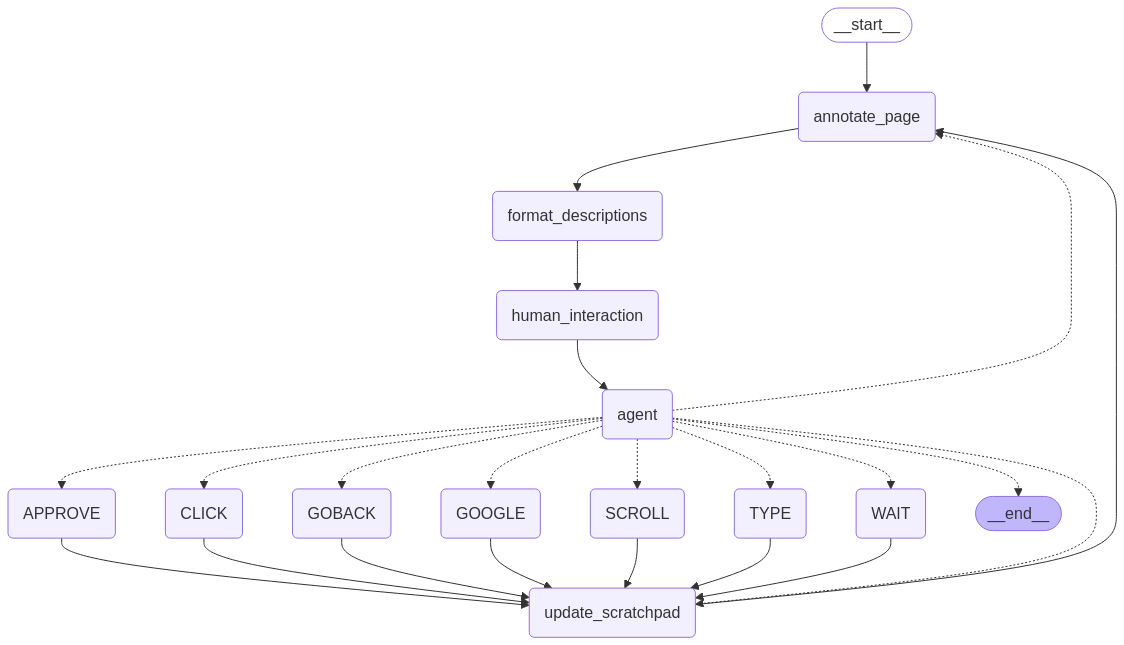

In [24]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [25]:
from IPython import display
from playwright.async_api import async_playwright
import asyncio
import uuid
import base64

config ={
    "thread_id": str(uuid.uuid4()),
    "recursion_limit": 150,
    }

# Run the agent
async def test_agent(query: str, config: dict = config):
    # Start Playwright
    playwright = await async_playwright().start()

    # Launch the browser
    browser = await playwright.chromium.launch(
        executable_path="/usr/bin/chromium-browser",
        headless=False,  # Set to False to watch the agent navigate
        args=[
            '--no-sandbox',
            '--disable-blink-features=AutomationControlled',
        ],
    )

    # Open a new page
    page = await browser.new_page()

    # Navigate to Google
    await page.goto("https://www.google.com")
    await page.wait_for_selector("text=Godta alle", timeout=5000)  # Wait up to 5 seconds
    await page.click("text=Godta alle") 

    # Create an initial AgentState
    state = AgentState(
        page=page,
        input=query,
        img=None,
        bboxes=[],
        prediction=None,
        scratchpad=[],
        observation=None,
        ids=[]
    )

    final_answer = None
    steps = []

    # Run the agent
    try:
        # Iterate over the asynchronous generator
        event_stream = graph.astream(
            state,
            config=config,
        )

        async for event in event_stream:
            # Log relevant event details
            if "agent" in event:
                print("\n--- Agent Event ---")
                pred = event["agent"].get("prediction") or {}
                action = pred.action
                action_input = pred.args
                print(f"Action: {action}")
                print(f"Action Input: {action_input}")
                print(f"Observation: {event['agent'].get('observation')}")
                print(f"Scratchpad: {event['agent'].get('scratchpad', [])}")
                print(f"Bounding Boxes: {event['agent'].get('bboxes', [])}")
                print(f"Image: {event['agent'].get('img')}")
                display.clear_output(wait=True)
                steps.append(f"{len(steps) + 1}. {action}: {action_input}")
                print("\n".join(steps))
                display.display(display.Image(base64.b64decode(event["agent"]["img"])))
                if action == "ANSWER":
                    print(f"\nFinal answer: {action_input[0]}")
                    final_answer = action_input[0]
                    break

        print("Agent completed successfully.")
    finally:
        # Close the browser
        await browser.close()
        await playwright.stop()

    return final_answer

In [26]:
instructions = """ 
1. When pop box with  (<a/>): "informasjonskapsler" pops up. Use scroll to make it visible and click on "godta alle"
2. If you see (<a/>): "Godta alle" click on it to accept cookies.
3. Go to finn.no
3. In finn.no find the Search and search for 'BMW iX xDrive40 2022'.
4. Click on the car.
5. Find the car's specifications.
6. Give me a summary of the car's specifications and features.
"""

# Run the test
res = await test_agent(
query=instructions,
)

Bounding boxes: [{'x': 868.890625, 'y': 48, 'type': 'div', 'text': 'no', 'ariaLabel': ''}, {'x': 956.6953125, 'y': 48, 'type': 'div', 'text': 'Logg på', 'ariaLabel': ''}, {'x': 392.8203125, 'y': 156, 'type': 'a', 'text': 'informasjonskapsler', 'ariaLabel': ''}]
Annotated bounding boxes: [{'x': 868.890625, 'y': 48, 'type': 'div', 'text': 'no', 'ariaLabel': ''}, {'x': 956.6953125, 'y': 48, 'type': 'div', 'text': 'Logg på', 'ariaLabel': ''}, {'x': 392.8203125, 'y': 156, 'type': 'a', 'text': 'informasjonskapsler', 'ariaLabel': ''}]


AttributeError: 'NoneType' object has no attribute 'action'

In [ ]:
# Run the test
res = await test_agent(
query=instructions,
)

Bounding boxes: [{'x': 868.890625, 'y': 48, 'type': 'div', 'text': 'no', 'ariaLabel': ''}, {'x': 956.6953125, 'y': 48, 'type': 'div', 'text': 'Logg på', 'ariaLabel': ''}, {'x': 392.8203125, 'y': 156, 'type': 'a', 'text': 'informasjonskapsler', 'ariaLabel': ''}]
Agent completed successfully.


In [ ]:
state_values = graph.get_state(config=config).values
state_values

{}

# Compile the Graph
Compile the agent's graph by defining nodes, edges, and conditional logic for tool selection.